In [85]:
#multi channel CNN for sentiment analysis
from nltk.corpus import stopwords
from string import punctuation
import pandas as pd
import numpy as np
import re
import csv
import codecs
import word2vecReader as godin_embedding
import pickle
from random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from math import sqrt
from gensim.models import KeyedVectors
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

In [86]:
#loading data
def load_data_from_file(filename):
    print("loading file = ",filename)
    sentences = []
    label = []
    with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            try:
                sentences.append(row[0])
                label.append(row[1])
            except:
                print(row)
    return sentences,label

In [87]:
# sentences,score = load_data_from_xml('dataset/financial_posts_ABSA_train.xml')
trainX,trainY = load_data_from_file('dataset/final_train.csv')
devX,devY = load_data_from_file('dataset/final_dev.csv')

loading file =  dataset/final_train.csv
loading file =  dataset/final_dev.csv


In [88]:
len(trainX),len(trainY)

(10890, 10890)

In [89]:
len(devX),len(devY)

(111, 111)

In [90]:
trainY.count('1'),devY.count('1')

(5653, 54)

In [91]:
trainY.count('0'),devY.count('0')

(5237, 57)

In [92]:
# #only using 1%data for testing code
trainX = trainX[:100]
trainY = trainY[:100]
devX = devX[:10]
devY = devY[:10]

In [93]:
# turn a sentence into clean tokens
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #removing stock names to see if it helps
#     sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation.replace('$',''))
    tokens = [w.translate(table) for w in tokens]
#     remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [94]:
# extract sentences out of df and cleaning it
print('cleaning train set')
trainX = [clean_sentence(x) for x in trainX]
print('cleaning dev set')
devX = [clean_sentence(x) for x in devX]
# sentences

cleaning train set
cleaning dev set


In [95]:
print(len(trainX),len(trainY))
print(len(devX),len(devY))

100 100
10 10


In [96]:
#converting output matrix [-ve,+ve]
devY = to_categorical(devY,2)
trainY = to_categorical(trainY,2)

In [97]:
lengths = [len(s.split()) for s in trainX]
max_length = max(lengths)

(array([0.1       , 0.06428571, 0.14285714, 0.03571429, 0.07857143,
        0.12857143, 0.06428571, 0.02857143, 0.02857143, 0.04285714]),
 array([ 2. ,  3.4,  4.8,  6.2,  7.6,  9. , 10.4, 11.8, 13.2, 14.6, 16. ]),
 <a list of 10 Patch objects>)

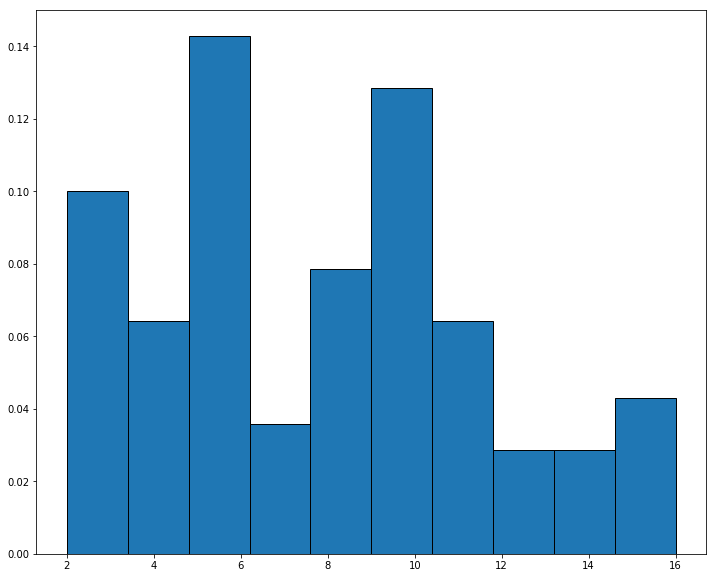

In [98]:
plt.subplots(figsize=(12,10))
plt.hist(lengths, normed=True,edgecolor='black')

In [99]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [65]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

In [66]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading the model, this can take some time...")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [67]:
godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")

Loading the model, this can take some time...


In [100]:
def get_embedding_matrix(model,sentence,godin_flag = False):
    tokens = sentence.split()[:max_length]
    if godin_flag:
        embedding_matrix = np.zeros((max_length,400))
    else:
        embedding_matrix = np.zeros((max_length,300))
    for i,word in enumerate(tokens):
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [101]:
print("bulding word2vec matrix of train set")
train_word2vec = np.asarray([get_embedding_matrix(word2vec_model,x) for x in trainX])
print("bulding godin matrix of train set")
train_godin = np.asarray([get_embedding_matrix(godin_model,x,godin_flag=True) for x in trainX])
print("bulding word2vec matrix of dev set")
dev_word2vec = np.asarray([get_embedding_matrix(word2vec_model,x) for x in devX])
print("bulding godin matrix of dev set")
dev_godin = np.asarray([get_embedding_matrix(godin_model,x,godin_flag=True) for x in devX])

bulding word2vec matrix of train set
bulding godin matrix of train set
bulding word2vec matrix of dev set
bulding godin matrix of dev set


In [102]:
train_word2vec.shape

(100, 16, 300)

In [103]:
para_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',name='learning_rate')

In [104]:
para_dropout = Real(low=0.4, high=0.9,name = 'dropout')

In [105]:
# para_n_dense = Integer(low=100, high=400, name='n_dense')
para_n_dense = Categorical(categories=[100,200,300,400], name='n_dense')

In [106]:
# para_n_filters = Integer(low=100,high=400,name='n_filters')
para_n_filters = Categorical(categories=[100,200,300,400],name='n_filters')

In [107]:
para_filter_size_c1 = Integer(low=1,high=6,name = 'filter_size_c1')
para_filter_size_c2 = Integer(low=1,high=6,name = 'filter_size_c2')
para_filter_size_c3 = Integer(low=1,high=6,name = 'filter_size_c3')

In [108]:
para_em_c1 = Categorical(categories=['embedding_matrix_godin','embedding_matrix_word2vec'],name='em_c1')
para_em_c2 = Categorical(categories=['embedding_matrix_godin','embedding_matrix_word2vec'],name='em_c2')
para_em_c3 = Categorical(categories=['embedding_matrix_godin','embedding_matrix_word2vec'],name='em_c3')

In [109]:
para_batch_size = Categorical(categories=[50,100,150],name='batch_size')

In [110]:
para_epoch = Categorical(categories=[10,50,100,200,300,400,500],name='epoch')

In [111]:
parameters = [para_learning_rate,para_dropout,para_n_dense,para_n_filters,para_filter_size_c1,para_filter_size_c2,para_filter_size_c3,para_em_c1,para_em_c2,para_em_c3,para_batch_size,para_epoch]

In [112]:
default_parameters = [1e-4,0.5,100,100,2,4,6,'embedding_matrix_word2vec','embedding_matrix_godin','embedding_matrix_word2vec',50,10]

In [113]:
def define_model(length,n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3):
    # channel 1
    if em_c1 == 'embedding_matrix_word2vec':
        inputs1 = Input(shape=(length,300))
    else:
        inputs1 = Input(shape=(length,400))
#     if em_c1 == 'free':
#         embedding1 = Embedding(vocab_size, free_em_dim)(inputs1)
#     else:
#         embedding1 = Embedding(vocab_size, len(eval(em_c1)[0]), weights = [eval(em_c1)],input_length=length,trainable = em_trainable_flag)(inputs1)

    conv1 = Conv1D(filters=n_filters, kernel_size=filter_size_c1, activation='relu')(inputs1)
    drop1 = Dropout(dropout)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    if em_c2 == 'embedding_matrix_word2vec':
        inputs2 = Input(shape=(length,300))
    else:
        inputs2 = Input(shape=(length,400))
#     embedding2 = Embedding(vocab_size, 400, weights = [embedding_matrix_godin],input_length=length,trainable = em_trainable_flag)(inputs2)
#     if em_c2 == 'free':
#         embedding2 = Embedding(vocab_size, free_em_dim)(inputs2)
#     else:
#         embedding2 = Embedding(vocab_size, len(eval(em_c2)[0]), weights = [eval(em_c2)],input_length=length,trainable = em_trainable_flag)(inputs2)
    conv2 = Conv1D(filters=n_filters, kernel_size=filter_size_c2, activation='relu')(inputs2)
    drop2 = Dropout(dropout)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    if em_c1 == 'embedding_matrix_word2vec':
        inputs3 = Input(shape=(length,300))
    else:
        inputs3 = Input(shape=(length,400))
#     embedding3 = Embedding(vocab_size, 400)(inputs3)
#     if em_c3 == 'free':
#         embedding3 = Embedding(vocab_size, free_em_dim)(inputs3)
#     else:
#         embedding3 = Embedding(vocab_size, len(eval(em_c3)[0]), weights = [eval(em_c3)],input_length=length,trainable = em_trainable_flag)(inputs3)
    conv3 = Conv1D(filters=n_filters, kernel_size=filter_size_c3, activation='relu')(inputs3)
    drop3 = Dropout(dropout)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(n_dense, activation='relu')(merged)
    outputs = Dense(2, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # summarize
    print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [114]:
#dict to store performance of all models
record = dict()
key=0

In [118]:
@use_named_args(dimensions=parameters)
def fitness(learning_rate,dropout,n_dense,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,batch_size,epoch):
# n_dense,dropout,learning_rate,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,free_em_dim,em_trainable_flag
    # Print the hyper-parameters.
    global key
    global record
    print('-----------------------------combination no={0}------------------'.format(key))
    print('learning rate ==>',learning_rate)
    print('dropout==>',dropout)
    print('n_dense==>',n_dense)
    print('n_filters==>',n_filters)
    print('filter_size_c1',filter_size_c1)
    print('filter_size_c2',filter_size_c2)
    print('filter_size_c3',filter_size_c3)
    print('em_c1==>',em_c1)
    print('em_c2==>',em_c2)
    print('em_c3==>',em_c3)
    print('batch_size==>',batch_size)
    print('epocs==>',epoch)

    # Create the neural network with these hyper-parameters.
    model = define_model(length = max_length,
                         n_dense=n_dense,
                         dropout=dropout,
                         learning_rate=learning_rate,
                         n_filters=n_filters,
                         filter_size_c1=int(filter_size_c1),
                         filter_size_c2=int(filter_size_c2),
                         filter_size_c3=int(filter_size_c3),
                         em_c1=em_c1,
                         em_c2=em_c2,
                         em_c3=em_c3)
    input_train_array = [train_word2vec if x=='embedding_matrix_word2vec' else train_godin for x in [em_c1,em_c2,em_c3]]
    input_dev_array = [dev_word2vec if x=='embedding_matrix_word2vec' else dev_godin for x in [em_c1,em_c2,em_c3]]
    
    # Use Keras to train the model.
    history_object = model.fit(input_train_array, trainY,epochs=epoch, batch_size=batch_size,validation_data=(input_dev_array,devY))

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history_object.history['val_acc'][-1]

    # Print the classification accuracy.
    print("Accuracy: {0:.2%}".format(accuracy))
    
    
    record[key] = {'parameters':[learning_rate,dropout,n_dense,n_filters,filter_size_c1,filter_size_c2,filter_size_c3,em_c1,em_c2,em_c3,batch_size,epoch],'val_acc':accuracy}
    
    model.save('models/'+str(key)+'.h5')
    
    with open('models/record.pickle', 'wb') as handle:
        pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    key+=1
    
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy

In [119]:
fitness(x=default_parameters)

-----------------------------combination no=0------------------
learning rate ==> 0.0001
dropout==> 0.5
n_dense==> 100
n_filters==> 100
filter_size_c1 2
filter_size_c2 4
filter_size_c3 6
em_c1==> embedding_matrix_word2vec
em_c2==> embedding_matrix_godin
em_c3==> embedding_matrix_word2vec
batch_size==> 50
epocs==> 10
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16, 300)      0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 16, 400)      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 16, 300)      0                                  

-0.5

In [ ]:
search_result = gp_minimize(func=fitness,
                            dimensions=parameters,
                            acq_func='EI',
                            n_calls=11,
                            x0=default_parameters)

In [ ]:
with open('models/record.pickle', 'wb') as handle:
    pickle.dump(record, handle, protocol=pickle.HIGHEST_PROTOCOL)